<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Assignments/blob/master/Mask%20R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 5 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh

https://drive.google.com/open?id=18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv

https://drive.google.com/open?id=1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz

https://drive.google.com/open?id=1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a

https://drive.google.com/open?id=1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3a')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh': 'hw3_mycocodata_bboxes_comp_zlib.npy',
'18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv': 'hw3_mycocodata_img_comp_zlib.h5',
'1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz': 'hw3_mycocodata_labels_comp_zlib.npy',
'1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a': 'hw3_mycocodata_mask_comp_zlib.h5',
'1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ': 'checkpoint680.pth',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

In [0]:
import torch
from torchvision import datasets, transforms
import h5py
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

path =  Path("/content/gdrive/My Drive/CIS680_2019/HW3a")
hf_img = h5py.File(path /'hw3_mycocodata_img_comp_zlib.h5', 'r')['data']
# images_data = hf_img['data'][0].transpose((1,2,0))
images_data = hf_img[0].transpose(1,2,0)
# print(images_data.shape, images_data)

hf_masks = h5py.File(path /'hw3_mycocodata_mask_comp_zlib.h5', 'r')['data']
masks_data = hf_masks[0]
# print(masks_data.shape, masks_data)

bboxes_data = np.load(path /'hw3_mycocodata_bboxes_comp_zlib.npy',allow_pickle=True)
bbox = torch.Tensor(bboxes_data[1])
print(bbox)

tensor([[167.0000, 100.1627, 312.8072, 204.6747],
        [119.4217,  57.3916, 232.4819, 190.3675]])


# PyTorch Dataset

Copy your HW3a dataset code

In [0]:
# Dataset class 

import torch
from torchvision import datasets, transforms
import h5py
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

class HW3Dataset(torch.utils.data.Dataset):
  def __init__(self, path,transform):
    self.path = path
    self.labels_data = np.load(path /'hw3_mycocodata_labels_comp_zlib.npy',allow_pickle=True)
    
    self.images_data = h5py.File(path /'hw3_mycocodata_img_comp_zlib.h5', 'r')['data']
    
    self.count = len(self.images_data)
    self.transform = transform
    self.gridscale = 16
    self.anchor_width = 128
    self.anchor_height = 128

    # scale bounding boxes
    bboxs_data = np.load(path /'hw3_mycocodata_bboxes_comp_zlib.npy',allow_pickle=True)
    for bboxs in bboxs_data:
      bboxs[:,0] = bboxs[:,0]* 1088/400
      bboxs[:,2] = bboxs[:,2]* 1088/400
      bboxs[:,1] = bboxs[:,1]* 800/300
      bboxs[:,3] = bboxs[:,3]* 800/300

    self.bboxes_data = bboxs_data

    #group and scale masks    
    hf_masks = h5py.File(path /'hw3_mycocodata_mask_comp_zlib.h5', 'r')['data']
    
    mask_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((800,1066)),
     transforms.Pad((11,0), fill=0, padding_mode='constant'),
     transforms.ToTensor(),
     ])
    
    processed_masks = []
    mask_index = 0
    for i,labels in enumerate(self.labels_data):
      tmp_masks = []
      for j,label in enumerate(labels):
        mask = mask_transform(hf_masks[mask_index].astype(np.uint8).reshape(300,400,1))
        mask_index += 1
        tmp_masks.append(mask)

      processed_masks.append(tmp_masks)
      
    self.masks_data = processed_masks

    # self.masks_data = hf_masks

  def __getitem__(self, index):
    
    label = torch.Tensor(self.labels_data[index])
    bbox = torch.Tensor(self.bboxes_data[index].astype(int))
    mask = self.masks_data[index]
    # target = {'label': label , 'bbox':bbox , 'mask':mask ,'rpn_gt': rpn_gt} 
    image = self.transform(self.images_data[index].astype(np.uint8).transpose(1,2,0))
    return image, label, bbox, mask
  
  def __len__(self):
    count = self.count
    return count # number of images  

In [0]:
# Create test and train splits

torch.manual_seed(0)

#!!!!!!!!!!change to wherever data is located
data_folder = Path("/content/gdrive/My Drive/CIS680_2019/HW3a")

red = (255,0,0) #people
green = (0,255,0) #vehicle
blue = (0,0,255) #animals

inv_normalize =  transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


transform = transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize((800,1066)),
     transforms.Pad((11,0), fill=0, padding_mode='constant'),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     ])

dataset = HW3Dataset(data_folder, transform)

def my_collate(batch):

    # images and rpn_gts are tensors, labels, bboxes, masks are list of tensors  

    # print(len(batch))
    images = []
    labels = []
    bboxs = []
    masks = []
 
    for item in batch:
      # print(item[0].shape)
      # print(item[1])
      # print(item[2])
      # print(item[3])
      # print(item[4])
      
      images.append(item[0])
      labels.append(item[1])
      bboxs.append(item[2])
      masks.append(item[3])
 
    images = torch.stack(images)
    # labels = torch.stack(labels)
    # bboxs = torch.stack(bboxs)
    # masks = torch.stack(masks)
    return images, labels, bboxs, masks

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(trainset),len(testset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, collate_fn=my_collate)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, collate_fn=my_collate)
# sample_testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, collate_fn=my_collate)


2285 980


# Dataset test

We suggest coming up with a test for your dataset. Testing and confirming that all of this works as expected here will save you headache later.

image_index=2533
tensor([[380., 282., 635., 570.],
        [389., 165., 593., 471.]])
Vehicle
Person


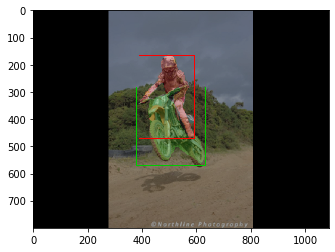

In [0]:
import cv2


def plot_labels(image, labels,bboxs,masks):
  # labels = target['label']
  # masks = target['mask'] 
  # bboxs = target['bbox']
  # rpn_gt = target['rpn_gt']
  # print(rpn_gt)
  # print("positive = {}, negative = {}, neutral = {}".format((rpn_gt[0]>0).nonzero().shape[0], (rpn_gt[0]==0).nonzero().shape[0], (rpn_gt[0]<0).nonzero().shape[0]))
  
  img = np.array(to_pil_image(inv_normalize(image)))
  # print(img.shape,img.dtype)
  # plt.figure()  
  # plt.imshow(img)

  masked_img = img
  # print(img.shape)
  for i,label in enumerate(labels):    
    
    # plot mask
    
    # print(masks[i].shape)
    mask = cv2.cvtColor(255*np.array(to_pil_image(masks[i])),cv2.COLOR_GRAY2RGB)
    # print(mask.shape)
    if label == 1:
      color = green
      mask[:,:,(0,2)] = 0
      print("Vehicle")
    elif label == 2:
      color = red
      mask[:,:,(1,2)] = 0 
      print("Person")
    elif label == 3:
      color = blue
      mask[:,:,(0,1)] = 0
      print("Animal")
    
    # masked_img = img
    cv2.addWeighted(mask, 0.2, img, 0.8, 0, masked_img)  

    # plot bounding boxes
    x1,y1,x2,y2 = bboxs[i]
    cv2.rectangle(masked_img, (x1, y1), (x2, y2), color, 2)    
  
  plt.figure()  
  plt.imshow(masked_img)

index = random.randint(0,len(dataset)) 
index = 2533  #interesting image indices - 2215,1826,105,688,2533,2798,1183
print("image_index={}" .format(index))
image,label,bbox,mask = dataset[index]
print(bbox)
plot_labels(image,label,bbox,mask)


# Load Checkpoint and plot rpn proposals and roi align crops
Here is some sample code to load the pretrained model we are providing

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.4MB/s]


torch.Size([1, 256, 200, 272])
(336, 590)
(311, 530)
(404, 481)
(409, 469)
(368, 623)
[tensor([[ 47.4391,  36.0644, 194.9424, 120.1327],
        [ 22.6763,  41.3027, 155.4119, 119.0636],
        [ 60.9914,  25.2844, 181.3076, 126.4059],
        ...,
        [162.8247,  73.5671, 180.1051,  90.1874],
        [120.3582,   0.0000, 191.4767,  78.1815],
        [260.1848, 195.7777, 272.0000, 200.0000]], device='cuda:0')]
torch.Size([1000, 256, 7, 7])


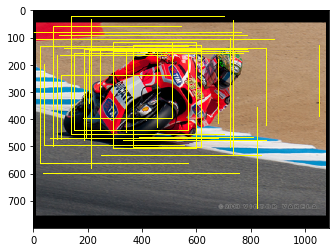

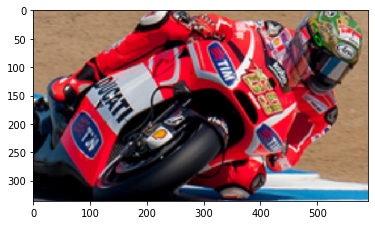

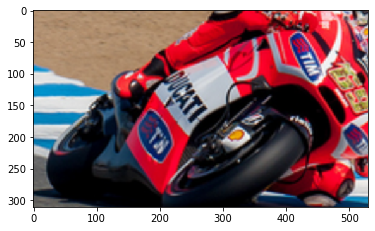

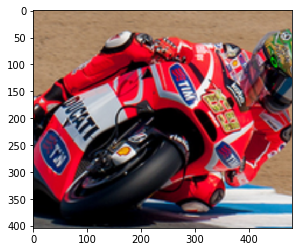

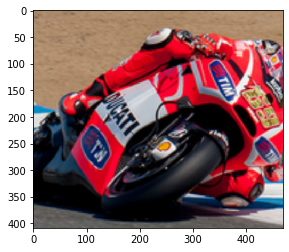

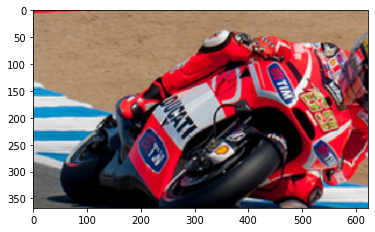

In [0]:
import torchvision
import torch
from pathlib import Path
import cv2

data_folder = Path("/content/gdrive/My Drive/CIS680_2019/HW3a")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def pretrained_model_680(checkpoint_file):

    import torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    
    model.eval()
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    backbone = model.backbone
    rpn = model.rpn
    
    checkpoint = torch.load(checkpoint_file)
    
    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])
    
    return backbone, rpn

def plot_proposals(image,rpn_out):

  img = np.array(to_pil_image(inv_normalize(image.squeeze(0)).detach().cpu()))
  # print(img.shape)
  bboxs = rpn_out[0][0]
  # perm = torch.randperm(bboxs.size(0))
  # idx = perm[:100]
  bbox_samples = bboxs[:50]
  color = (255,255,0)
    
  for box in bbox_samples:
    # plot bounding boxes
    x1,y1,x2,y2 = box
    
    if x1 >= 0 and x2<img.shape[1] and y1 >= 0 and y2<img.shape[0]:
      # print(x1,y1,x2,y2)
      cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)    
  
  plt.figure()  
  plt.imshow(img)

def plot_roialign_crops(image,rpn_out):
  # roialign_out = torchvision.ops.roi_align(image, rpnout[0], output_size=(800,1088), spatial_scale=1.0, sampling_ratio=-1)
  # print(roialign_out.shape)

  img = np.array(to_pil_image(image.squeeze(0).detach().cpu()))
  # print(img.shape)
  bboxs = rpn_out[0][0]
  # perm = torch.randperm(bboxs.size(0))
  # idx = perm[:5]
  bbox_samples = bboxs[:5]
  color = (255,255,0)

  for box in bbox_samples:
    x1,y1,x2,y2 = box.cpu().numpy()
    box_size = (int(y2-y1),int(x2-x1))
    print(box_size)
    roialign_out = torchvision.ops.roi_align(image, [box.unsqueeze(0)], output_size=box_size, spatial_scale=1.0, sampling_ratio=-1)
    # print(roialign_out.shape, roialign_out)
    roi_crop_img = np.array(to_pil_image(inv_normalize(roialign_out.squeeze(0)).detach().cpu()))
    plt.figure()  
    plt.imshow(roi_crop_img)


backbone,rpn_model = pretrained_model_680( data_folder /'checkpoint680.pth')

# index = random.randint(0,len(dataset)) 

index = 2798  #interesting image indices - 2215,1826,105,688,2533,2798

image,label,bbox,mask = dataset[index]
image = image.unsqueeze(0).to(device)
# print(image.shape)
backbone.eval()
backboneout = backbone(image)
layer_2 = backboneout[0]
print(layer_2.shape)

from torchvision.models.detection.image_list import ImageList 
im_lis = ImageList(image, [(800,1088)])

rpn_model.eval()
rpnout = rpn_model(im_lis,backboneout)
# print(rpnout[0][0].shape)

plot_proposals(image,rpnout)

plot_roialign_crops(image,rpnout)

rpnout_scaled_down = [rpn/4 for rpn in rpnout[0]]

print(rpnout_scaled_down)

roialign_out = torchvision.ops.roi_align(layer_2, rpnout_scaled_down, output_size=(7,7), spatial_scale=1.0, sampling_ratio=-1)
print(roialign_out.shape)

# Model Definition

Define the four models

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import cv2
from torchvision.models.detection.image_list import ImageList 

data_folder = Path("/content/gdrive/My Drive/CIS680_2019/HW3a")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ROIAlign(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(256*7*7,1024,bias=True)
    self.bn1 = nn.BatchNorm1d(1024)
    self.fc2 = nn.Linear(1024,1024,bias=True)
    self.bn2 = nn.BatchNorm1d(1024)

    
  def forward(self,receptive_field_scale, fpn_layer, rpnboxes):
    # rpnboxes_scaled_down = [box/receptive_field_scale for box in rpnboxes]   #receptive field between layer-2 and input-image is 4 (1088/272,800/200), bbox from rpn are in input image dimensions
    rpnboxes_scaled_down = rpnboxes/receptive_field_scale
    # print(rpnboxes_scaled_down.is_leaf)
    roialign_out = torchvision.ops.roi_align(fpn_layer, [rpnboxes_scaled_down], output_size=(7,7), spatial_scale=1.0, sampling_ratio=-1)
    X = roialign_out.flatten(1)
    X = F.relu(self.bn1(self.fc1(X)))
    X = F.relu(self.bn2(self.fc2(X)))
    return X

class Classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(1024,4,bias=True)
    
    
  def forward(self, X):
    X = self.fc1(X) # No non-linearity before CELoss as we are predicting scores(can be positive and negative) for each class, softmax will convert them into probabilities 
    #then CE loss will compare the max(output) from softmax with the target/groundtruth class 
    return X

class Regressor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(1024,4*4,bias=True) #take smooth l1 loss
    
  def forward(self, X):
    X = self.fc1(X) #no non linearity because parametrized
    return X

class Masks(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(256)
    self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.conv5 = nn.ConvTranspose2d(in_channels=256, out_channels=256,stride=2, kernel_size=2, padding=0)
    self.bn5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=4, kernel_size=1,padding=0)
    
  def forward(self, X):
    X = F.relu(self.bn1(self.conv1(X)))
    X = F.relu(self.bn2(self.conv2(X)))
    X = F.relu(self.bn3(self.conv3(X)))
    X = F.relu(self.bn4(self.conv4(X)))
    X = F.relu(self.bn5(self.conv5(X)))
    # print(X.shape)
    X = torch.sigmoid(self.conv6(X))
    return X

def pretrained_model_680(checkpoint_file):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    model.eval()
    model.to(device)    
    backbone = model.backbone
    rpn = model.rpn
    checkpoint = torch.load(checkpoint_file)
    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])
    return backbone, rpn

backbone_model,rpn_model = pretrained_model_680( data_folder /'checkpoint680.pth')
roialign_intmodel = ROIAlign().to(device)
classifier_model = Classifier().to(device)
regressor_model = Regressor().to(device)
mask_model = Masks().to(device)


for param in backbone_model.parameters():
    param.requires_grad = False

for param in rpn_model.parameters():
    param.requires_grad = False

backbone_model.eval()
rpn_model.eval() 

# print(backbone_model)
# print(rpn_model)
print(roialign_intmodel)
print(classifier_model)
print(regressor_model)
print(mask_model)  

ROIAlign(
  (fc1): Linear(in_features=12544, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Classifier(
  (fc1): Linear(in_features=1024, out_features=4, bias=True)
)
Regressor(
  (fc1): Linear(in_features=1024, out_features=16, bias=True)
)
Masks(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Co

In [0]:
# sanity check for all models

def convert_xywh(box):
  x1,y1,x2,y2 = box
  converted_box = box.detach().clone()
  converted_box[0],converted_box[1],converted_box[2],converted_box[3] = (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)
  return converted_box

def parameterize_coordinates(rpn_box,gt_pred_box):
  x_a,y_a,w_a,h_a = convert_xywh(rpn_box)
  x,y,w,h = convert_xywh(gt_pred_box)
  parametrized_box = rpn_box.detach().clone()
  parametrized_box[0],parametrized_box[1],parametrized_box[2],parametrized_box[3] = (x-x_a)/w_a,(y-y_a)/h_a,torch.log(w/w_a),torch.log(h/h_a)
  return parametrized_box

def preprocess_proposals(rpnboxes,labels,bboxs):
  rpnboxes = rpnboxes[:100]
  # print(rpnboxes.shape, bboxs.shape)
  ious = torchvision.ops.box_iou(rpnboxes,bboxs)    
  # print(ious.shape)
  
  positive_idx = (ious>0.5).nonzero()
  negative_idx = (ious<=0.5).nonzero()
  # print(positive_idx.shape,negative_idx.shape, positive_idx.shape[0]/negative_idx.shape[0])
  # print(positive_idx)
  gt_classifier = torch.zeros([rpnboxes.shape[0]],device=device, requires_grad=False) #################check if you really need this????????
  gt_regressor = torch.zeros([rpnboxes.shape[0],4],device=device, requires_grad=False) 
  gt_regressor_gt = torch.zeros([rpnboxes.shape[0],4],device=device, requires_grad=False) 
  
  for idx in positive_idx:
    m,n = idx
    gt_box, gt_label,rpn_box = bboxs[n],labels[n],rpnboxes[m]
    gt_classifier[m] = gt_label.detach().clone()
    gt_regressor[m] = parameterize_coordinates(rpn_box,gt_box)
    gt_regressor_gt[m] = gt_box.detach().clone()
    
  return rpnboxes, gt_classifier, gt_regressor,gt_regressor_gt


for image,labels,bboxs,masks in trainloader:
  with torch.no_grad():
    image = image.to(device)
    labels = labels[0].to(device)   ################# batch size is 1 
    bboxs = bboxs[0].to(device)
    print(labels,bboxs)

    backboneout = backbone_model(image)
    fpn_layer = backboneout[0] #layer2
    receptive_field_scale = 4
    # print(fpn_layer.shape)

    im_lis = ImageList(image, [(800,1088)])
    rpnout = rpn_model(im_lis,backboneout)
    print(rpnout[0][0].shape)

    subsampled_rpnout,gt_classifier,gt_regressor,gt_regressor_gt = preprocess_proposals(rpnout[0][0],labels,bboxs)
    print(subsampled_rpnout.shape, subsampled_rpnout.requires_grad)
    
    torch.set_printoptions(precision=5)
    print(gt_classifier.shape,gt_regressor.shape,gt_regressor_gt.shape)
    
    roialign_out = roialign_intmodel(receptive_field_scale,fpn_layer,subsampled_rpnout)
    print(roialign_out.shape)
    
    cls_out = classifier_model(roialign_out)
    print(cls_out.shape)

    reg_out = regressor_model(roialign_out)
    print(reg_out.shape)

    reg_out = reg_out.reshape(reg_out.shape[0],4,4)
    reg_out = reg_out[:,0,:]
    print(reg_out.shape)
    
    roialign_masks = torchvision.ops.roi_align(fpn_layer, [reg_out], output_size=(14,14), spatial_scale=1.0, sampling_ratio=-1)
    print(roialign_masks.shape)
    mask_out = mask_model(roialign_masks)
    print(mask_out.shape)

    break

tensor([3.], device='cuda:0') tensor([[ 74., 224., 867., 623.]], device='cuda:0')
torch.Size([1000, 4])
torch.Size([100, 4]) False
torch.Size([100]) torch.Size([100, 4]) torch.Size([100, 4])
torch.Size([100, 1024])
torch.Size([100, 4])
torch.Size([100, 16])
torch.Size([100, 4])
torch.Size([100, 256, 14, 14])
torch.Size([100, 256, 28, 28])
torch.Size([100, 4, 28, 28])


# Train your network

It might be good to save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

In [0]:
torch.cuda.empty_cache()

params = list(roialign_intmodel.parameters()) + list(classifier_model.parameters()) + list(regressor_model.parameters())
optimizer = optim.Adam(params, lr = 0.001)

cls_loss_criterion = nn.CrossEntropyLoss(reduction='mean')
reg_loss_criterion = nn.SmoothL1Loss(reduction='mean')

regressor_training_loss=[]
classifier_training_loss=[]
total_training_loss=[]

testing_loss = []
testing_acc = []
testing_recall = []
testing_precision = []

epochs = 15

def convert_xywh(box):
  x1,y1,x2,y2 = box
  # converted_box = torch.zeros(box.shape,device=device)
  # converted_box[0],converted_box[1],converted_box[2],converted_box[3] = (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)
  return (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)

def parameterize_coordinates(rpn_box,gt_pred_box):
  x_a,y_a,w_a,h_a = convert_xywh(rpn_box)
  x,y,w,h = convert_xywh(gt_pred_box)
  # parametrized_box = torch.zeros(gt_pred_box.shape,device=device)
  # parametrized_box[0],parametrized_box[1],parametrized_box[2],parametrized_box[3] = (x-x_a)/w_a,(y-y_a)/h_a,torch.log(w/w_a),torch.log(h/h_a)
  return (x-x_a)/w_a,(y-y_a)/h_a,torch.log(w/w_a),torch.log(h/h_a)

def preprocess_proposals(rpnboxes,labels,bboxs):
  rpnboxes = rpnboxes[0][:100]       #change code here for batchsize > 1
  # print(rpnboxes.shape, bboxs.shape)
  ious = torchvision.ops.box_iou(rpnboxes,bboxs)    
  # print(ious.shape)
  
  positive_idx = (ious>0.5).nonzero()
  negative_idx = (ious<=0.5).nonzero()
  # print(positive_idx.shape,negative_idx.shape, positive_idx.shape[0]/negative_idx.shape[0])
  # print(positive_idx)
  gt_classifier = torch.zeros([rpnboxes.shape[0]], dtype=torch.long, device=device, requires_grad=False) #################check if you really need this????????
  gt_regressor = torch.zeros([rpnboxes.shape[0],4],device=device, requires_grad=False) 
  gt_regressor_gt = torch.zeros([rpnboxes.shape[0],4],device=device, requires_grad=False) 
  
  for idx in positive_idx:
    m,n = idx
    gt_box, gt_label,rpn_box = bboxs[n],labels[n],rpnboxes[m]
    gt_classifier[m] = gt_label.clone()
    gt_regressor[m][0],gt_regressor[m][1],gt_regressor[m][2],gt_regressor[m][3] = parameterize_coordinates(rpn_box,gt_box)
    # gt_regressor[m] = convert_xywh(rpn_box)
    gt_regressor_gt[m] = gt_box.clone()
    
  return rpnboxes, gt_classifier, gt_regressor,gt_regressor_gt


def compute_cls_loss(pred_cls,gt_cls):
  # print(pred_cls.shape, gt_cls.shape, pred_cls, gt_cls)
  loss = cls_loss_criterion(pred_cls,gt_cls)
  accuracy,precision,recall = 0.,0.,0.
  return loss

def compute_reg_loss(pred_reg, gt_reg, gt_cls, cls_loss):
  pred_reg = pred_reg.reshape(pred_reg.shape[0],4,4)
  sampled_pred_idx = []
  
  for i,label in enumerate(gt_cls):
    if label.item()!=0:
      sampled_pred_idx.append(torch.tensor([i,label],dtype=torch.long))     
  
  if len(sampled_pred_idx)>0:
    sampled_pred_idx = torch.stack(sampled_pred_idx).split(1, dim=1)
    # print(sampled_pred_idx[0])
    sampled_pred_reg = pred_reg[sampled_pred_idx].squeeze(1)
    # print(sampled_pred_reg.shape)
    sampled_gt_reg = gt_reg[sampled_pred_idx[0]].squeeze(1)
    # print(sampled_gt_reg.shape)
    loss = reg_loss_criterion(sampled_pred_reg,sampled_gt_reg)
  else:
    loss = Variable(torch.tensor(0.)).type_as(cls_loss.data)

  return loss  

for e in range(epochs):
  running_total_loss = 0.0
  running_reg_loss = 0.0
  running_cls_loss = 0.0

  for image,labels,bboxs,masks in trainloader:
    # with torch.no_grad():
    image = image.to(device)
    labels = labels[0].to(device)   ################# change code here for batch_size>1
    bboxs = bboxs[0].to(device)
    
    optimizer.zero_grad()
    
    backboneout = backbone_model(image)
    fpn_layer = backboneout[0] #layer2
    receptive_field_scale = 4  #layer2 
    # print(fpn_layer.shape)

    im_lis = ImageList(image, [(800,1088)])
    rpnboxes,_ = rpn_model(im_lis,backboneout)
    
    subsampled_rpnboxes,gt_classifier, gt_regressor,gt_regressor_gt = preprocess_proposals(rpnboxes,labels,bboxs)
    # print(subsampled_rpnboxes.shape)
    
    roialign_after_int = roialign_intmodel(receptive_field_scale,fpn_layer,subsampled_rpnboxes)
    # print(roialign_after_int.shape)

    cls_out = classifier_model(roialign_after_int)
    cls_loss = compute_cls_loss(cls_out,gt_classifier)
        
    reg_out = regressor_model(roialign_after_int)
    reg_loss = 10*compute_reg_loss(reg_out,gt_regressor,gt_classifier,cls_loss)

    total_loss = cls_loss + reg_loss
    
    total_loss.backward()

    # print(cls_loss,reg_loss)
    # break
    optimizer.step()
    
    running_total_loss += total_loss.item()
    running_reg_loss += reg_loss.item()
    running_cls_loss += cls_loss.item()

  total_training_loss.append(running_total_loss/len(trainloader))
  regressor_training_loss.append(running_reg_loss/len(trainloader))
  classifier_training_loss.append(running_cls_loss/len(trainloader))

  print("Epoch {} - Reg_loss: {}, Cls_loss: {}, Total = {}".format(e,regressor_training_loss[-1],classifier_training_loss[-1],total_training_loss[-1] ))


Epoch 0 - Reg_loss: 0.36086249185534486, Cls_loss: 0.37150010667920635, Total = 0.732362599374168
Epoch 1 - Reg_loss: 0.140089608116699, Cls_loss: 0.2734158222814227, Total = 0.41350542999461654
Epoch 2 - Reg_loss: 0.08972033856220592, Cls_loss: 0.23403948013725767, Total = 0.3237598190357179
Epoch 3 - Reg_loss: 0.0603789053953108, Cls_loss: 0.19731913957687774, Total = 0.2576980452731871
Epoch 4 - Reg_loss: 0.05055051305304797, Cls_loss: 0.16100588577271682, Total = 0.21155639901855058
Epoch 5 - Reg_loss: 0.042425885975474996, Cls_loss: 0.12357374271133373, Total = 0.16599962867519266
Epoch 6 - Reg_loss: 0.03714066521698686, Cls_loss: 0.08659795333653754, Total = 0.1237386185341643
Epoch 7 - Reg_loss: 0.033376512019151185, Cls_loss: 0.061049049320484, Total = 0.0944255612480823
Epoch 8 - Reg_loss: 0.030083089769375664, Cls_loss: 0.04650120867076951, Total = 0.07658429849746126
Epoch 9 - Reg_loss: 0.027902110043049055, Cls_loss: 0.03315212564476403, Total = 0.06105423566296338
Epoch 10

KeyboardInterrupt: ignored

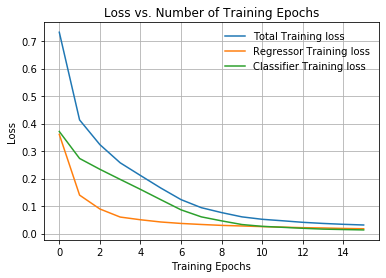

In [0]:
torch.save({'roialign_intmodel_state_dict': roialign_intmodel.state_dict(),'classifier_model_state_dict':classifier_model.state_dict(),'regressor_model_state_dict':regressor_model.state_dict()}, data_folder / 'maskrcnn_1.pt')

plt.figure()
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(total_training_loss, label='Total Training loss')
plt.plot(regressor_training_loss, label='Regressor Training loss')
plt.plot(classifier_training_loss, label='Classifier Training loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

# Test your network

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.

Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal
Animal


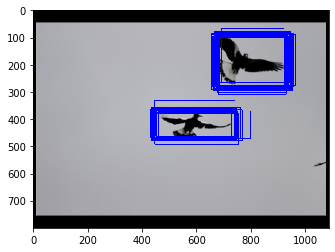

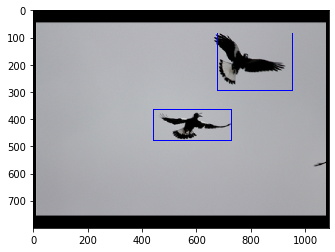

In [0]:
roialign_intmodel.load_state_dict(torch.load(data_folder / 'maskrcnn_1.pt')['roialign_intmodel_state_dict'])
roialign_intmodel.eval()

classifier_model.load_state_dict(torch.load(data_folder / 'maskrcnn_1.pt')['classifier_model_state_dict'])
classifier_model.eval()

regressor_model.load_state_dict(torch.load(data_folder / 'maskrcnn_1.pt')['regressor_model_state_dict'])
regressor_model.eval()

torch.set_printoptions(precision=5)


def convert_xywh(box):
  x1,y1,x2,y2 = box
  # converted_box = torch.zeros(box.shape,device=device)
  # converted_box[0],converted_box[1],converted_box[2],converted_box[3] = (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)
  return (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)

def convert_x1y1x2y2(box):
  x,y,w,h = box
  # converted_box = torch.zeros(box.shape,device=device)
  # converted_box[0],converted_box[1],converted_box[2],converted_box[3] = (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)
  return x-w/2, y-h/2, x+w/2, y+h/2

def parameterize_coordinates(rpn_box,gt_pred_box):
  x_a,y_a,w_a,h_a = convert_xywh(rpn_box)
  x,y,w,h = convert_xywh(gt_pred_box)
  # parametrized_box = torch.zeros(gt_pred_box.shape,device=device)
  # parametrized_box[0],parametrized_box[1],parametrized_box[2],parametrized_box[3] = (x-x_a)/w_a,(y-y_a)/h_a,torch.log(w/w_a),torch.log(h/h_a)
  return (x-x_a)/w_a,(y-y_a)/h_a,torch.log(w/w_a),torch.log(h/h_a)

def decode_box(rpn_box, reg_box):  
  x_a,y_a,w_a,h_a = convert_xywh(rpn_box)
  tx,ty,tw,th = reg_box
  converted_reg_box = tx*w_a+x_a , ty*h_a+y_a, torch.exp(tw)*w_a, torch.exp(th)*h_a
  x1,y1,x2,y2 = convert_x1y1x2y2(converted_reg_box)
  if x1<0:
    x1=0
  elif x1>1087:
    x1 = 1087  
  
  if y1<0:
    y1=0
  elif y1>799:
    y1 = 799  
  
  if x2<0:
    x2=0
  elif x2>1087:
    x2 = 1087   
  
  if y2<0:
    y2=0
  elif y2>799:
    y2 = 799  

  return x1,y1,x2,y2


def postprocess_proposals(cls_out,reg_out,rpnboxes):
  torch.set_printoptions(precision=5)

  reg_out = reg_out.reshape(reg_out.shape[0],4,4)  
  
  m = nn.Softmax(dim=1)
  
  scores,labels = torch.max(m(cls_out),dim=1)
  
  processed_labels = []
  processed_boxes = []
  processed_scores = []
  
  for i,label in enumerate(labels):
    if label!=0:
      rpn_box,reg_box = rpnboxes[i],reg_out[i,label].squeeze(0)
      decoded_box = torch.tensor(decode_box(rpn_box,reg_box),dtype=torch.float32, device=device, requires_grad=True)
      # if (decoded_box < 0).nonzero().nelement() > 0:
      #   decoded_box[decoded_box < 0] = 0.
      processed_boxes.append(decoded_box)
      processed_labels.append(label)
      processed_scores.append(scores[i])

  if len(processed_labels)>0:
    processed_boxes = torch.stack(processed_boxes)
    processed_labels = torch.stack(processed_labels)
    processed_scores = torch.stack(processed_scores)
    
    # print(labels, processed_labels)

    nms_boxes = []
    nms_labels = []

    for i in range(1,4):
      class_idx = (processed_labels==i).nonzero().squeeze(1)
      # print(class_idx.shape)
      if class_idx.nelement() > 0:
        # print("class = {}".format(i))
        class_boxes = processed_boxes[class_idx]
        class_labels = processed_labels[class_idx]
        box_scores = processed_scores[class_idx]
        # print(box_scores.shape,class_labels.shape)
        nms_kept_idx = torchvision.ops.nms(class_boxes,box_scores,0.2)
        # print(class_boxes[nms_kept_idx].shape,class_labels[nms_kept_idx])
        # print(nms_kept_idx.shape)
        for kept_idx in nms_kept_idx:
          nms_boxes.append(class_boxes[kept_idx].squeeze(0))
          nms_labels.append(class_labels[kept_idx].squeeze(0))

    nms_boxes = torch.stack(nms_boxes)
    nms_labels = torch.stack(nms_labels)
    
    # print(nms_labels.shape,nms_labels,nms_boxes.shape)
    return nms_labels,nms_boxes,processed_labels,processed_boxes
  
  else:
    tmp = torch.tensor([-1])
    return tmp,tmp,tmp,tmp

def plot_labels(image,labels,bboxs):
  
  img = np.array(to_pil_image(inv_normalize(image)))
  # plt.figure()  
  # plt.imshow(img)

  masked_img = img
  # print(img.shape)
  for i,label in enumerate(labels):    
    
    # plot mask
    
    # print(masks[i].shape)
    # mask = cv2.cvtColor(255*np.array(to_pil_image(masks[i])),cv2.COLOR_GRAY2RGB)
    # print(mask.shape)
    if label == 1:
      color = green
      # mask[:,:,(0,2)] = 0
      print("Vehicle")
    elif label == 2:
      color = red
      # mask[:,:,(1,2)] = 0 
      print("Person")
    elif label == 3:
      color = blue
      # mask[:,:,(0,1)] = 0
      print("Animal")
    
    # masked_img = img
    # cv2.addWeighted(mask, 0.2, img, 0.8, 0, masked_img)  

    # plot bounding boxes
    x1,y1,x2,y2 = bboxs[i]
    cv2.rectangle(masked_img, (x1, y1), (x2, y2), color, 2)    
  
  plt.figure()  
  plt.imshow(masked_img)

for image,_,_,_ in testloader:
    
  with torch.no_grad():
    image = image.to(device)
      
    backboneout = backbone_model(image)
    fpn_layer = backboneout[0] #layer2
    receptive_field_scale = 4  #layer2 
    # print(fpn_layer.shape)

    im_lis = ImageList(image, [(800,1088)])
    rpnboxes,_ = rpn_model(im_lis,backboneout)
    
    subsampled_rpnboxes = rpnboxes[0][0:100]

    roialign_after_int = roialign_intmodel(receptive_field_scale,fpn_layer,subsampled_rpnboxes)
    # print(roialign_after_int.shape)

    cls_out = classifier_model(roialign_after_int)
        
    reg_out = regressor_model(roialign_after_int)
    
    nms_labels,nms_boxes,processed_labels,processed_boxes = postprocess_proposals(cls_out,reg_out,subsampled_rpnboxes)

    plot_labels(image.squeeze(0).detach().cpu(),processed_labels,processed_boxes)
    plot_labels(image.squeeze(0).detach().cpu(),nms_labels,nms_boxes)
    break


# Train with MASKS

In [0]:
roialign_intmodel.load_state_dict(torch.load(data_folder / 'maskrcnn_1.pt')['roialign_intmodel_state_dict'])
# roialign_intmodel.eval()

classifier_model.load_state_dict(torch.load(data_folder / 'maskrcnn_1.pt')['classifier_model_state_dict'])
# classifier_model.eval()

regressor_model.load_state_dict(torch.load(data_folder / 'maskrcnn_1.pt')['regressor_model_state_dict'])
# regressor_model.eval()

torch.cuda.empty_cache()

params = list(roialign_intmodel.parameters()) + list(classifier_model.parameters()) + list(regressor_model.parameters()) + list(mask_model.parameters())
optimizer = optim.Adam(params, lr = 0.001)

cls_loss_criterion = nn.CrossEntropyLoss(reduction='mean')
reg_loss_criterion = nn.SmoothL1Loss(reduction='mean')
mask_loss_criterion = nn.BCELoss(reduction='mean')

regressor_training_loss=[]
classifier_training_loss=[]
mask_training_loss=[]
total_training_loss=[]

epochs = 12

def convert_xywh(box):
  x1,y1,x2,y2 = box
  # converted_box = torch.zeros(box.shape,device=device)
  # converted_box[0],converted_box[1],converted_box[2],converted_box[3] = (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)
  return (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)

def convert_x1y1x2y2(box):
  x,y,w,h = box
  # converted_box = torch.zeros(box.shape,device=device)
  # converted_box[0],converted_box[1],converted_box[2],converted_box[3] = (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)
  return x-w/2, y-h/2, x+w/2, y+h/2

def parameterize_coordinates(rpn_box,gt_pred_box):
  x_a,y_a,w_a,h_a = convert_xywh(rpn_box)
  x,y,w,h = convert_xywh(gt_pred_box)
  # parametrized_box = torch.zeros(gt_pred_box.shape,device=device)
  # parametrized_box[0],parametrized_box[1],parametrized_box[2],parametrized_box[3] = (x-x_a)/w_a,(y-y_a)/h_a,torch.log(w/w_a),torch.log(h/h_a)
  return (x-x_a)/w_a,(y-y_a)/h_a,torch.log(w/w_a),torch.log(h/h_a)

def decode_box(rpn_box, reg_box):  
  x_a,y_a,w_a,h_a = convert_xywh(rpn_box)
  tx,ty,tw,th = reg_box
  converted_reg_box = tx*w_a+x_a , ty*h_a+y_a, torch.exp(tw)*w_a, torch.exp(th)*h_a
  x1,y1,x2,y2 = convert_x1y1x2y2(converted_reg_box)
  if x1<0:
    x1=0
  elif x1>1087:
    x1 = 1087  
  
  if y1<0:
    y1=0
  elif y1>799:
    y1 = 799  
  
  if x2<0:
    x2=0
  elif x2>1087:
    x2 = 1087   
  
  if y2<0:
    y2=0
  elif y2>799:
    y2 = 799  

  return x1,y1,x2,y2

def preprocess_proposals(rpnboxes,labels,bboxs):
  rpnboxes = rpnboxes[0][:100]       #change code here for batchsize > 1
  # print(rpnboxes.shape, bboxs.shape)
  ious = torchvision.ops.box_iou(rpnboxes,bboxs)    
  # print(ious.shape)
  
  positive_idx = (ious>0.5).nonzero()
  negative_idx = (ious<=0.5).nonzero()
  # print(positive_idx.shape,negative_idx.shape, positive_idx.shape[0]/negative_idx.shape[0])
  # print(positive_idx)
  gt_classifier = torch.zeros([rpnboxes.shape[0]], dtype=torch.long, device=device, requires_grad=False) #################check if you really need this????????
  gt_regressor = torch.zeros([rpnboxes.shape[0],4],device=device, requires_grad=False) 
  gt_regressor_gt = torch.zeros([rpnboxes.shape[0],4],device=device, requires_grad=False) 
  
  for idx in positive_idx:
    m,n = idx
    gt_box, gt_label,rpn_box = bboxs[n],labels[n],rpnboxes[m]
    gt_classifier[m] = gt_label.clone()
    gt_regressor[m][0],gt_regressor[m][1],gt_regressor[m][2],gt_regressor[m][3] = parameterize_coordinates(rpn_box,gt_box)
    gt_regressor_gt[m] = gt_box.clone()
    
  return rpnboxes, gt_classifier, gt_regressor,gt_regressor_gt


def postprocess_proposals(cls_out,reg_out,rpnboxes):
  torch.set_printoptions(precision=5)

  reg_out = reg_out.reshape(reg_out.shape[0],4,4)  
  
  m = nn.Softmax(dim=1)
  
  scores,labels = torch.max(m(cls_out),dim=1)
  
  processed_labels = []
  processed_boxes = []
  processed_scores = []
  
  for i,label in enumerate(labels):
    if label!=0:
      rpn_box,reg_box = rpnboxes[i],reg_out[i,label].squeeze(0)
      decoded_box = torch.tensor(decode_box(rpn_box,reg_box),dtype=torch.float32, device=device, requires_grad=True)
      # if (decoded_box < 0).nonzero().nelement() > 0:
      #   decoded_box[decoded_box < 0] = 0.
      processed_boxes.append(decoded_box)
      processed_labels.append(label)
      processed_scores.append(scores[i])

  if len(processed_labels)>0:
    processed_boxes = torch.stack(processed_boxes)
    processed_labels = torch.stack(processed_labels)
    processed_scores = torch.stack(processed_scores)
    
    # print(labels, processed_labels)

    nms_boxes = []
    nms_labels = []

    for i in range(1,4):
      class_idx = (processed_labels==i).nonzero().squeeze(1)
      # print(class_idx.shape)
      if class_idx.nelement() > 0:
        # print("class = {}".format(i))
        class_boxes = processed_boxes[class_idx]
        class_labels = processed_labels[class_idx]
        box_scores = processed_scores[class_idx]
        # print(box_scores.shape,class_labels.shape)
        nms_kept_idx = torchvision.ops.nms(class_boxes,box_scores,0.4)
        # print(class_boxes[nms_kept_idx].shape,class_labels[nms_kept_idx])
        # print(nms_kept_idx.shape)
        for kept_idx in nms_kept_idx:
          nms_boxes.append(class_boxes[kept_idx].squeeze(0))
          nms_labels.append(class_labels[kept_idx].squeeze(0))

    nms_boxes = torch.stack(nms_boxes)
    nms_labels = torch.stack(nms_labels)
    
    # print(nms_labels.shape,nms_labels,nms_boxes.shape)
    return nms_labels,nms_boxes,processed_labels,processed_boxes
  
  else:
    tmp = torch.tensor([-1])
    return tmp,tmp,tmp,tmp

def compute_cls_loss(pred_cls,gt_cls):
  # print(pred_cls.shape, gt_cls.shape, pred_cls, gt_cls)
  loss = cls_loss_criterion(pred_cls,gt_cls)
  accuracy,precision,recall = 0.,0.,0.
  return loss

def compute_reg_loss(pred_reg, gt_reg, gt_cls, cls_loss):
  pred_reg = pred_reg.reshape(pred_reg.shape[0],4,4)
  
  tmp = torch.linspace(0,gt_cls.shape[0]-1,steps=gt_cls.shape[0],device=device)

  sampled_pred_idx = torch.cat((tmp.unsqueeze(1).type(torch.LongTensor),gt_cls.unsqueeze(1).type(torch.LongTensor)),dim=1)

  # sampled_pred_idx = []
  # for i,label in enumerate(gt_cls):
  #   if label.item()!=0:
  #     sampled_pred_idx.append(torch.tensor([i,label],dtype=torch.long))

  # print(sampled_pred_idx.shape,sampled_pred_idx)

  if len(sampled_pred_idx)>0:
    # sampled_pred_idx = torch.stack(sampled_pred_idx).split(1, dim=1)
    sampled_pred_idx = sampled_pred_idx.split(1, dim=1)
    # print(sampled_pred_idx[0])
    sampled_pred_reg = pred_reg[sampled_pred_idx].squeeze(1)
    # print(sampled_pred_reg.shape)
    sampled_gt_reg = gt_reg[sampled_pred_idx[0]].squeeze(1)
    # print(sampled_gt_reg.shape)
    loss = reg_loss_criterion(sampled_pred_reg,sampled_gt_reg)
  else:
    loss = Variable(torch.tensor(0.)).type_as(cls_loss.data)

  return loss  

def compute_mask_loss(pred_masks,labels,boxes,gt_masks):
  # print(gt_masks.shape,labels.shape)
  loss = 0
  for i,label in enumerate(labels):
    if gt_masks.shape[0] >= i+1:
      gt_mask = gt_masks[i]
    else:
      gt_mask = gt_masks[0]

    gt_mask[gt_mask>0] = 1
    box = boxes[i]
    # print(pred_masks.shape,label)
    pred_mask = pred_masks[i,label].unsqueeze(0)
    
    # print(pred_mask.shape)
    x1,y1,x2,y2 = box.type(torch.LongTensor)
    # print(gt_mask.shape,x2,x1,y2,y1)
    cropped_gt_mask = gt_mask[0,y1:y2,x1:x2].unsqueeze(0).unsqueeze(0)
    # print(cropped_gt_mask.shape)
    resized_cropped_gt_mask = F.interpolate(cropped_gt_mask,(28,28),mode='bilinear',align_corners=True).squeeze(0)
    # print(resized_cropped_gt_mask.shape,resized_cropped_gt_mask)
    loss += mask_loss_criterion(pred_mask,resized_cropped_gt_mask)
  # print(loss)
  loss = loss/(i+1)
  return loss  

for e in range(epochs):
  running_total_loss = 0.0
  running_reg_loss = 0.0
  running_cls_loss = 0.0
  running_mask_loss = 0.0  

  for image,labels,bboxs,masks in trainloader:
  # with torch.no_grad():
    image = image.to(device)
    labels = labels[0].to(device)   ################# change code here for batch_size>1
    bboxs = bboxs[0].to(device)
    masks = torch.stack(masks[0]).to(device)
    
    optimizer.zero_grad()
    
    backboneout = backbone_model(image)
    fpn_layer = backboneout[0] #layer2
    receptive_field_scale = 4  #layer2 
    # print(fpn_layer.shape)

    im_lis = ImageList(image, [(800,1088)])
    rpnboxes,_ = rpn_model(im_lis,backboneout)
    
    subsampled_rpnboxes,gt_classifier, gt_regressor,gt_regressor_gt = preprocess_proposals(rpnboxes,labels,bboxs)
    
    roialign_after_int = roialign_intmodel(receptive_field_scale,fpn_layer,subsampled_rpnboxes)
    # print(roialign_after_int.shape)

    cls_out = classifier_model(roialign_after_int)
    cls_loss = compute_cls_loss(cls_out,gt_classifier)
        
    reg_out = regressor_model(roialign_after_int)
    reg_loss = 10*compute_reg_loss(reg_out,gt_regressor,gt_classifier,cls_loss)
    
    nms_labels,nms_boxes,processed_labels,processed_boxes = postprocess_proposals(cls_out,reg_out,subsampled_rpnboxes)
    
    if nms_labels[0] == -1:
      break

    #plot_labels

    nms_boxes_scaled_down = nms_boxes/receptive_field_scale
    roialign_masks = torchvision.ops.roi_align(fpn_layer, [nms_boxes_scaled_down], output_size=(14,14), spatial_scale=1.0, sampling_ratio=-1)

    mask_out = mask_model(roialign_masks)

    mask_loss = 1*compute_mask_loss(mask_out,nms_labels,nms_boxes,masks)

    # processed_masks = postprocess_masks(masks_out,nms_labels,nms_boxes)

    total_loss = cls_loss + reg_loss + mask_loss    
    # print(cls_loss,reg_loss,mask_loss)
    
    total_loss.backward()
    # break
    
    optimizer.step()
    
    running_total_loss += total_loss.item()
    running_reg_loss += reg_loss.item()
    running_cls_loss += cls_loss.item()
    running_mask_loss += mask_loss.item()

  total_training_loss.append(running_total_loss/len(trainloader))
  regressor_training_loss.append(running_reg_loss/len(trainloader))
  classifier_training_loss.append(running_cls_loss/len(trainloader))
  mask_training_loss.append(running_mask_loss/len(trainloader))

  print("Epoch {} - Reg_loss: {}, Cls_loss: {}, Mask_loss:{}, Total = {}".format(e,regressor_training_loss[-1],classifier_training_loss[-1],mask_training_loss[-1],total_training_loss[-1] ))


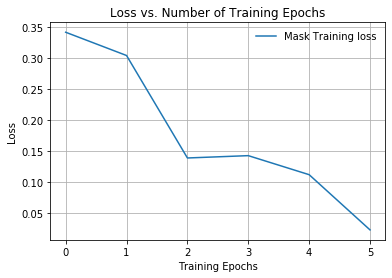

In [0]:
torch.save({'roialign_intmodel_state_dict': roialign_intmodel.state_dict(),'classifier_model_state_dict':classifier_model.state_dict(),'regressor_model_state_dict':regressor_model.state_dict(),'mask_model_state_dict':mask_model.state_dict() }, data_folder / 'maskrcnn_4.pt')


plt.figure()
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
# plt.plot(total_training_loss, label='Total Training loss')
# plt.plot(regressor_training_loss, label='Regressor Training loss')
# plt.plot(classifier_training_loss, label='Classifier Training loss')
plt.plot(mask_training_loss[0:6], label='Mask Training loss')

plt.legend(frameon=False)
plt.grid()
plt.show()

# Test MASKS 

Animal


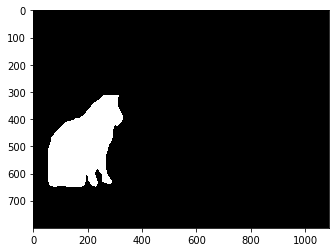

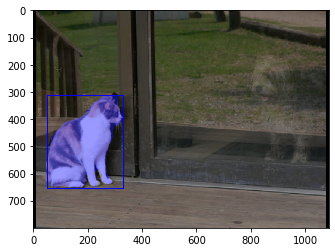

In [0]:
roialign_intmodel.load_state_dict(torch.load(data_folder / 'maskrcnn_4.pt')['roialign_intmodel_state_dict'])
roialign_intmodel.eval()

classifier_model.load_state_dict(torch.load(data_folder / 'maskrcnn_4.pt')['classifier_model_state_dict'])
classifier_model.eval()

regressor_model.load_state_dict(torch.load(data_folder / 'maskrcnn_4.pt')['regressor_model_state_dict'])
regressor_model.eval()

mask_model.load_state_dict(torch.load(data_folder / 'maskrcnn_4.pt')['mask_model_state_dict'])
mask_model.eval()

torch.set_printoptions(precision=5)


def convert_xywh(box):
  x1,y1,x2,y2 = box
  # converted_box = torch.zeros(box.shape,device=device)
  # converted_box[0],converted_box[1],converted_box[2],converted_box[3] = (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)
  return (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)

def convert_x1y1x2y2(box):
  x,y,w,h = box
  # converted_box = torch.zeros(box.shape,device=device)
  # converted_box[0],converted_box[1],converted_box[2],converted_box[3] = (x2+x1)/2,(y2+y1)/2,(x2-x1),(y2-y1)
  return x-w/2, y-h/2, x+w/2, y+h/2

def parameterize_coordinates(rpn_box,gt_pred_box):
  x_a,y_a,w_a,h_a = convert_xywh(rpn_box)
  x,y,w,h = convert_xywh(gt_pred_box)
  # parametrized_box = torch.zeros(gt_pred_box.shape,device=device)
  # parametrized_box[0],parametrized_box[1],parametrized_box[2],parametrized_box[3] = (x-x_a)/w_a,(y-y_a)/h_a,torch.log(w/w_a),torch.log(h/h_a)
  return (x-x_a)/w_a,(y-y_a)/h_a,torch.log(w/w_a),torch.log(h/h_a)

def decode_box(rpn_box, reg_box):  
  x_a,y_a,w_a,h_a = convert_xywh(rpn_box)
  tx,ty,tw,th = reg_box
  converted_reg_box = tx*w_a+x_a , ty*h_a+y_a, torch.exp(tw)*w_a, torch.exp(th)*h_a
  x1,y1,x2,y2 = convert_x1y1x2y2(converted_reg_box)
  if x1<0:
    x1=0
  elif x1>1087:
    x1 = 1087  
  
  if y1<0:
    y1=0
  elif y1>799:
    y1 = 799  
  
  if x2<0:
    x2=0
  elif x2>1087:
    x2 = 1087   
  
  if y2<0:
    y2=0
  elif y2>799:
    y2 = 799  

  return x1,y1,x2,y2

def postprocess_masks(labels,boxes,mask_out):
  
  resized_masks=[]

  for i,label in enumerate(labels):
    pred_mask = mask_out[i,label].unsqueeze(0).unsqueeze(0)
    box = boxes[i]
    x1,y1,x2,y2 = box.type(torch.LongTensor)
    resized_mask = F.interpolate(pred_mask,(y2-y1,x2-x1),mode='bilinear',align_corners=True).squeeze(0)
    resized_mask[resized_mask>=0.5] = 1
    resized_mask[resized_mask<0.5] = 0
    new_mask = torch.zeros((800,1088))
    new_mask[y1:y2,x1:x2] = resized_mask
    resized_masks.append(new_mask)
    
  resized_masks = torch.stack(resized_masks)
  
  return resized_masks  

def postprocess_proposals(cls_out,reg_out,rpnboxes):
  torch.set_printoptions(precision=5)

  reg_out = reg_out.reshape(reg_out.shape[0],4,4)  
  
  m = nn.Softmax(dim=1)
  
  scores,labels = torch.max(m(cls_out),dim=1)
  
  processed_labels = []
  processed_boxes = []
  processed_scores = []
  
  for i,label in enumerate(labels):
    if label!=0:
      rpn_box,reg_box = rpnboxes[i],reg_out[i,label].squeeze(0)
      decoded_box = torch.tensor(decode_box(rpn_box,reg_box),dtype=torch.float32, device=device, requires_grad=True)
      # if (decoded_box < 0).nonzero().nelement() > 0:
      #   decoded_box[decoded_box < 0] = 0.
      processed_boxes.append(decoded_box)
      processed_labels.append(label)
      processed_scores.append(scores[i])

  if len(processed_labels)>0:
    processed_boxes = torch.stack(processed_boxes)
    processed_labels = torch.stack(processed_labels)
    processed_scores = torch.stack(processed_scores)
    
    # print(labels, processed_labels)

    nms_boxes = []
    nms_labels = []

    for i in range(1,4):
      class_idx = (processed_labels==i).nonzero().squeeze(1)
      # print(class_idx.shape)
      if class_idx.nelement() > 0:
        # print("class = {}".format(i))
        class_boxes = processed_boxes[class_idx]
        class_labels = processed_labels[class_idx]
        box_scores = processed_scores[class_idx]
        # print(box_scores.shape,class_labels.shape)
        nms_kept_idx = torchvision.ops.nms(class_boxes,box_scores,0.2)
        # print(class_boxes[nms_kept_idx].shape,class_labels[nms_kept_idx])
        # print(nms_kept_idx.shape)
        for kept_idx in nms_kept_idx:
          nms_boxes.append(class_boxes[kept_idx].squeeze(0))
          nms_labels.append(class_labels[kept_idx].squeeze(0))

    nms_boxes = torch.stack(nms_boxes)
    nms_labels = torch.stack(nms_labels)
    
    # print(nms_labels.shape,nms_labels,nms_boxes.shape)
    return nms_labels,nms_boxes,processed_labels,processed_boxes
  
  else:
    tmp = torch.tensor([-1])
    return tmp,tmp,tmp,tmp

def plot_labels(image,labels,bboxs,masks):
  
  img = np.array(to_pil_image(inv_normalize(image)))
  # plt.figure()  
  # plt.imshow(img)

  masked_img = img
  # print(img.shape)
  for i,label in enumerate(labels):    
    
    # plot mask
    
    # print(masks[i].shape)
    
    # mask = cv2.cvtColor(255*np.array(to_pil_image(masks[i].squeeze(0))),cv2.COLOR_GRAY2RGB)
    mask = np.array(to_pil_image(masks[i]).convert("RGB"))
    # print(mask.shape)
    plt.figure()  
    plt.imshow(mask)
    
    if label == 1:
      color = green
      mask[:,:,(0,2)] = 0
      print("Vehicle")
    elif label == 2:
      color = red
      mask[:,:,(1,2)] = 0 
      print("Person")
    elif label == 3:
      color = blue
      mask[:,:,(0,1)] = 0
      print("Animal")
    
    masked_img = img
    cv2.addWeighted(mask, 0.4, img, 0.6, 0, masked_img)  

    # plot bounding boxes
    x1,y1,x2,y2 = bboxs[i]
    cv2.rectangle(masked_img, (x1, y1), (x2, y2), color, 2)    
  
  plt.figure()  
  plt.imshow(masked_img)

inv_normalize =  transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

transform = transforms.Compose(
    [
     transforms.Resize((800,1066)),
     transforms.Pad((11,0), fill=0, padding_mode='constant'),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     ])


for image,_,_,_ in testloader:
  # from PIL import Image   
  # im = Image.open(data_folder / "IMG_1940.jpg")
  # image = transform(im).unsqueeze(0)

  with torch.no_grad():
    image = image.to(device)
      
    backboneout = backbone_model(image)
    fpn_layer = backboneout[0] #layer2
    receptive_field_scale = 4  #layer2 
    # print(fpn_layer.shape)

    im_lis = ImageList(image, [(800,1088)])
    rpnboxes,_ = rpn_model(im_lis,backboneout)
    
    subsampled_rpnboxes = rpnboxes[0][0:100]

    roialign_after_int = roialign_intmodel(receptive_field_scale,fpn_layer,subsampled_rpnboxes)
    # print(roialign_after_int.shape)

    cls_out = classifier_model(roialign_after_int)
        
    reg_out = regressor_model(roialign_after_int)
    
    nms_labels,nms_boxes,processed_labels,processed_boxes = postprocess_proposals(cls_out,reg_out,subsampled_rpnboxes)

    # plot_labels(image.squeeze(0).detach().cpu(),processed_labels,processed_boxes)
    # plot_labels(image.squeeze(0).detach().cpu(),nms_labels,nms_boxes)

    if nms_labels[0] == -1:
      break

    nms_boxes_scaled_down = nms_boxes/receptive_field_scale
    roialign_masks = torchvision.ops.roi_align(fpn_layer, [nms_boxes_scaled_down], output_size=(14,14), spatial_scale=1.0, sampling_ratio=-1)

    mask_out = mask_model(roialign_masks)
    resized_masks = postprocess_masks(nms_labels,nms_boxes,mask_out)

    # plot_labels(image.squeeze(0).detach().cpu(),processed_labels,processed_boxes)
    plot_labels(image.squeeze(0).detach().cpu(),nms_labels,nms_boxes,resized_masks.detach().cpu())

    break
